In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.rcParams['axes.linewidth'] = 3

from ipywidgets import interactive, fixed
from scipy.interpolate import interp1d
import pywt
from scipy.ndimage import convolve

# Signal decomposition (Fourier, 1D Wavelet, 2D Wavelet)
## ELE8812 - H2018 (Joël Lefebvre)

Pour une version interactive de ce notebook: [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/joe-from-mtl/ele8812_Cours_AnalyseMultiresolution/master?filepath=notebooks%2FDemo_1DSignalDecomposition.ipynb)

## Signal to decompose

\begin{equation}
f(x) = x^2, \text{ for } x \in [0, 1]
\end{equation}

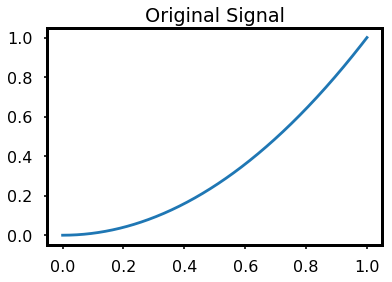

In [2]:
x = np.linspace(0, 1, 512); 
y = x**2 #* np.cos(x*6.0*np.pi)
plt.plot(x,y); plt.title('Original Signal')
plt.show()    

## Signal series expansions

\begin{equation}
f(x) = \sum_k \alpha_k \phi_k(x)
\end{equation}

where $\alpha_k$ are *expansion coefficients*, $\phi_k(x)$ are *expansion functions*. 

### Expansion coefficients
If $\{\phi_k(x)\}$ forms an orthonormal basis, the $\alpha_k$ are computed by taking the *integral inner product* of the basis $\phi_k(x)$ and function $f(x)$

\begin{equation}
\alpha_k = \langle\phi_k(x), f(x)\rangle = \int\phi^*_k(x) f(x) dx
\end{equation}

## Example 1: Fourier Transform 1D

For the Fourier series expansion, the expansion functions are given by

\begin{equation}
\phi_k(x) = e^{2 i \pi k x / T}
\end{equation}

In [3]:
k = 4
def phi_fourier(x, k):
    phi = np.exp(2.0j * np.pi * k * x)
    return phi

def plot_fourier_functions(k):
    plt.figure(figsize=(8,5))
    plt.plot(x, phi_fourier(x, k).real, label='Real part')
    plt.plot(x, phi_fourier(x, k).imag, label='Imaginary part')
    plt.title('Fourier basis function $\phi_k(x)$ for k={}'.format(k), y=1.05)
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1]); plt.xlabel('x')
    plt.ylim([-1.5, 1.5]); plt.ylabel('y')
    plt.legend(loc=1)
    plt.show() 

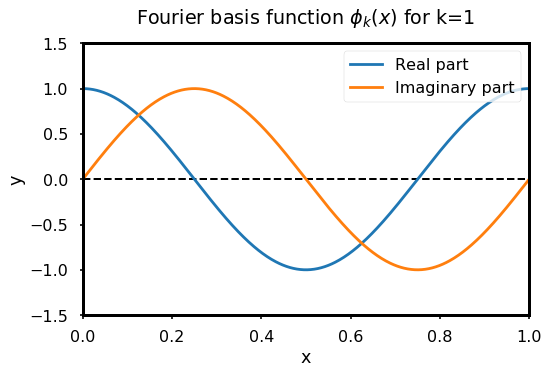

In [18]:
## Static example
plot_fourier_functions(1)

In [4]:
# Interactive Example
interactive(plot_fourier_functions, k=(0,16))

interactive(children=(IntSlider(value=8, description='k', max=16), Output()), _dom_classes=('widget-interact',))

## Compute the expansion coefficients

In [5]:
coeffs = dict()
nLevels = 10
for k in range(-nLevels, nLevels + 1):
    alpha = np.sum(y * np.conj(phi_fourier(x, k)))
    coeffs['a_{}'.format(k)] = alpha

In [6]:
def plot_reconstruction_fourier(x, y, coeffs, max_level=-1):
    if max_level == -1:
        max_level = (len(coeffs) - 1) / 2
    
    signal = None
    plt.figure(figsize=(8,5))
    for k in range(-max_level, max_level+1):
        alpha = coeffs['a_{}'.format(k)]
        phi = alpha * phi_fourier(x, k) / float(len(x))
        if signal is None:
            signal = phi
        else:
            signal += phi
        if k == max_level:
            label=r"$\alpha_k \phi_k(x)$"
        else:
            label = None
        plt.plot(x, phi.real, color=[0.2, 0.2, 1.0], alpha=0.5, label=label)
    
    plt.plot(x, y, color='k', label=r'$f(x)$')
    plt.plot(x, signal.real, color='r', label=r'$\frac{1}{N}\sum_k \alpha_k \phi_k(x)$')
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1]); plt.xlabel('x')
    plt.legend()
    plt.title(r"$|k| \leq %d$" % max_level, y=1.04)
    plt.show() 

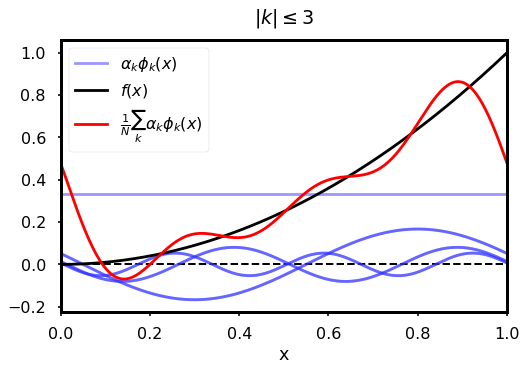

In [19]:
# Static Example
plot_reconstruction_fourier(x,y,coeffs,max_level=3)

In [20]:
# Dynamic Example
interactive(plot_reconstruction_fourier, x = fixed(x), y=fixed(y), coeffs=fixed(coeffs), max_level=(0,nLevels))

interactive(children=(IntSlider(value=0, description='max_level', max=10), Output()), _dom_classes=('widget-interact',))

## Scaling Functions

In [8]:
def get_scalingFunction(a, b, wavelet='haar', nSupport=1):
    phi_0, psi_0, x_0 = pywt.DiscreteContinuousWavelet(wavelet).wavefun(level=8)
    f = interp1d(x_0, phi_0, kind='linear', fill_value=0, bounds_error=False)
    w = x_0[-1] - x_0[0]
    xmin = x_0[0] - nSupport*w
    xmax = x_0[-1] + nSupport*w
    nSteps = int((2*nSupport + 1) * len(x_0))
    x = np.linspace(xmin, xmax, nSteps)
    phi = 2**(a/2.0)*f(2**a*x - b)
    return phi, x 

def display_scalingFunction(j_scale=0,k_translate=0,wavelet='haar'):
    phi, x = get_scalingFunction(j_scale, k_translate, wavelet)
    #plt.figure(figsize=(8,5))
    plt.fill_between(x, phi);
    plt.plot(x, phi, color='k');
    plt.axhline(0, color='k', alpha=0.5)
    plt.axvline(0, color='k', alpha=0.5)
    plt.title(r'$\varphi_{%d,%d}(x)$' % (j_scale, k_translate), y=1.05)
    #plt.show()

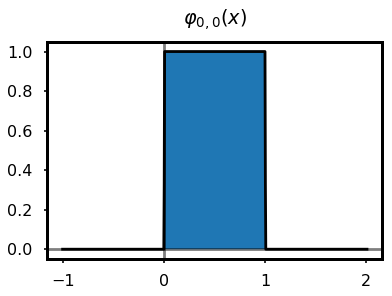

In [21]:
# Static Example
display_scalingFunction(0, 0, 'haar')

In [22]:
# Dynamic example
waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
interactive(display_scalingFunction, j_scale=(0,4), k_translate=(-10,10), wavelet=waveletList)

interactive(children=(IntSlider(value=0, description='j_scale', max=4), IntSlider(value=0, description='k_translate', max=10, min=-10), Dropdown(description='wavelet', options=('haar', 'db2', 'db3', 'db4', 'sym2', 'sym3'), value='haar'), Output()), _dom_classes=('widget-interact',))

## Wavelet functions

In [10]:
def get_waveletFunction(a, b, wavelet='haar', nSupport=1):
    phi_0, psi_0, x_0 = pywt.DiscreteContinuousWavelet(wavelet).wavefun(level=8)
    f = interp1d(x_0, psi_0, kind='linear', fill_value=0, bounds_error=False)
    w = x_0[-1] - x_0[0]
    xmin = x_0[0] - nSupport*w
    xmax = x_0[-1] + nSupport*w
    nSteps = int((2*nSupport + 1) * len(x_0))
    x = np.linspace(xmin, xmax, nSteps)
    psi = 2**(a/2.0)*f(2**a*x - b)
    return psi, x 

def display_waveletFunction(j_scale=0,k_translate=0,wavelet='haar'):
    psi, x = get_waveletFunction(j_scale, k_translate, wavelet)
    #plt.figure(figsize=(8,5))
    plt.fill_between(x, psi);
    plt.plot(x, psi, color='k');
    plt.axhline(0, color='k', alpha=0.5)
    plt.axvline(0, color='k', alpha=0.5)
    plt.title(r'$\psi_{%d,%d}(x)$' % (j_scale, k_translate), y=1.05)
    #plt.show()

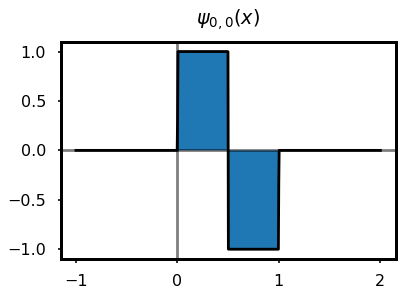

In [23]:
# Static Example
display_waveletFunction(0, 0, 'haar')

In [11]:
# Dynamic Example
waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
interactive(display_waveletFunction, j_scale=(0,4), k_translate=(-10,10), wavelet=waveletList)

interactive(children=(IntSlider(value=0, description='j_scale', max=4), IntSlider(value=0, description='k_translate', max=10, min=-10), Dropdown(description='wavelet', options=('haar', 'db2', 'db3', 'db4', 'sym2', 'sym3'), value='haar'), Output()), _dom_classes=('widget-interact',))

## Example : Decomposition using the Haar Wavelet Basis

\begin{equation}
f(x) = \sum_{k} c_{j_0}(k) \varphi_{j_0,k}(x) + \sum_{j\geq j_0}\sum_{k} d_j(x)\psi_{j,k}(x)
\end{equation}

** Scaling coefficients **
\begin{equation}
c_{j_0}(k) = \langle f(x), \varphi_{j_0,l}(x)\rangle = \int f(x) \varphi^*_{j_0, k}(x) dx
\end{equation}

** Wavelet coefficients **
\begin{equation}
d_{j}(k) = \langle f(x), \psi_{j,l}(x)\rangle = \int f(x) \psi^*_{j, k}(x) dx
\end{equation}

## Original signal, and Haar scaling and wavelet functions

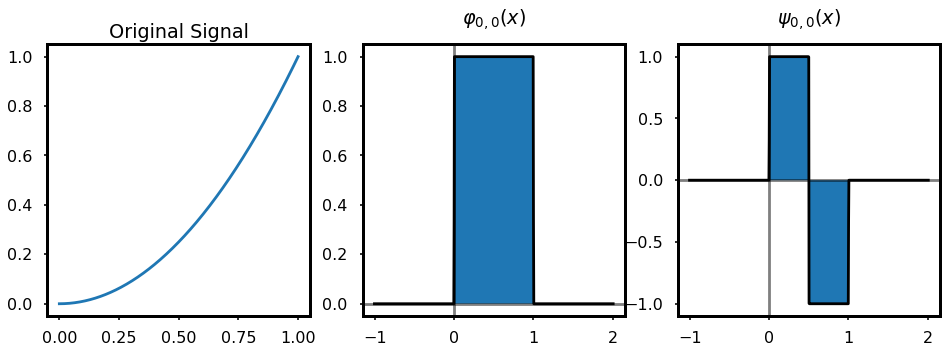

In [12]:
plt.figure(figsize=(16,5))
j = 0; k = 0;
plt.subplot(131); plt.plot(x,y); plt.title('Original Signal')
plt.subplot(132); display_scalingFunction(j,k)
plt.subplot(133); display_waveletFunction(j,k)
plt.show()

In [13]:
## Wavelet decomposition and reconstruction
def plot_reconstruction_haar(x, y, wavelet = 'haar', level=0):
    coeffs = pywt.wavedec(y, wavelet)
    signal = None
    plt.figure(figsize=(8,5))
    coeffs_recons = list()
    for k in range(len(coeffs)):
        if k > level+1:
            coeffs_recons.append(np.zeros(len(coeffs[k])))
        else:
            coeffs_recons.append(coeffs[k])
    signal = pywt.waverec(coeffs_recons, wavelet)
    plt.plot(x, y, color='b', label=r'$f(x)$')
    plt.plot(x, signal, color='r', label=r'$\frac{1}{N}\sum_k \alpha_k \phi_k(x)$')
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1]); plt.xlabel('x')
    plt.legend()
    plt.title(r"$|j| \leq %d$" % level, y=1.04)
    plt.show() 

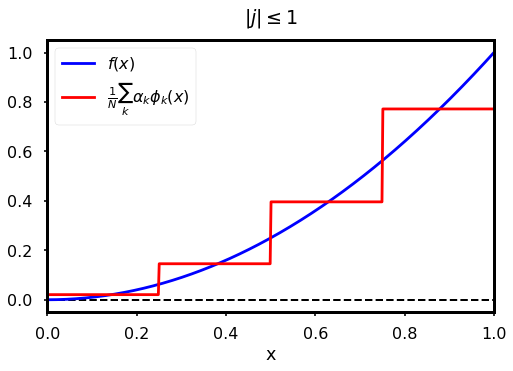

In [26]:
# Static Example
plot_reconstruction_haar(x,y,level=1,wavelet='haar')

In [25]:
# Dynamic Example
waveletList = ['haar', 'db2', 'sym2']
interactive(plot_reconstruction_haar, x = fixed(x), y=fixed(y), level=(0,8), wavelet=waveletList)

interactive(children=(Dropdown(description='wavelet', options=('haar', 'db2', 'sym2'), value='haar'), IntSlider(value=0, description='level', max=8), Output()), _dom_classes=('widget-interact',))

## 2D Extenstion

** 2D scaling function**
\begin{equation}
\varphi^{(2D)}(x,y) = \varphi(x) \varphi(y)
\end{equation}

** 2D wavelet functions**
\begin{equation}
\psi^{(H)}(x,y) = \psi(x) \varphi(y)
\end{equation}

\begin{equation}
\psi^{(V)}(x,y) = \varphi(x) \psi(y)
\end{equation}

\begin{equation}
\psi^{(D)}(x,y) = \psi(x) \psi(y)
\end{equation}

In [15]:
def display_2DScaling_and_Wavelet_Functions(j=0, m=0, n=0, wavelet='haar'):
    phi_x, x = get_scalingFunction(j, m, wavelet=wavelet, nSupport=0)
    psi_x, _ = get_waveletFunction(j, m, wavelet=wavelet, nSupport=0)
    phi_y, y = get_scalingFunction(j, n, wavelet=wavelet, nSupport=0)
    psi_y, _ = get_waveletFunction(j, n, wavelet=wavelet, nSupport=0)
    
    # In python X and Y are inverted
    phi_y2d = np.tile(np.reshape(phi_x, (len(x), 1)), (1, len(y)))
    psi_y2d = np.tile(np.reshape(psi_x, (len(x), 1)), (1, len(y)))
    phi_x2d = np.tile(np.reshape(phi_y, (1, len(y))), (len(x), 1))
    psi_x2d = np.tile(np.reshape(psi_y, (1, len(y))), (len(x), 1))
    
    # Computing the 2D Haar wavelet from these equations
    phi_2d = phi_x2d * phi_y2d
    psi_2d_H = psi_x2d * phi_y2d
    psi_2d_V = phi_x2d * psi_y2d   
    psi_2d_D = psi_x2d * psi_y2d

    # Displaying the 1D wavelet at the origin of the 2D functions
    plt.figure(figsize=(16,8))
    plt.subplot(231); 
    plt.plot(x,phi_x, label=r'$\phi(x)$'); 
    plt.plot(y,phi_y, label=r'$\phi(y)$');
    plt.legend()
    plt.title('1D Scaling functions', y=1.02); plt.xticks([])
    plt.subplot(234); 
    plt.plot(x,psi_x, label=r'$\psi(x)$'); 
    plt.plot(y,psi_y, label=r'$\psi(y)$'); 
    plt.title('1D Wavelet functions', y=1.02)
    plt.legend()

    plt.subplot(232); plt.imshow(phi_2d.T, origin='lower', cmap='gray'); plt.xticks([]); plt.yticks([])
    plt.title(r'$\varphi_{%d, %d, %d}(x,y)$' % (j, m, n), y=1.02)
    plt.subplot(233); plt.imshow(psi_2d_H.T, origin='lower', cmap='gray'); plt.xticks([]); plt.yticks([])
    plt.title(r'$\psi^{(H)}_{%d, %d, %d}(x,y)$' % (j, m, n), y=1.02)
    plt.subplot(235); plt.imshow(psi_2d_V.T, origin='lower', cmap='gray'); plt.xticks([]); plt.yticks([])
    plt.title(r'$\psi^{(V)}_{%d, %d, %d}(x,y)$' % (j, m, n), y=1.02)
    plt.subplot(236); plt.imshow(psi_2d_D.T, origin='lower', cmap='gray'); plt.xticks([]); plt.yticks([])
    plt.title(r'$\psi^{(D)}_{%d, %d, %d}(x,y)$' % (j, m, n), y=1.02)

    plt.show()

## Static 2D Scaling and Wavelet function example

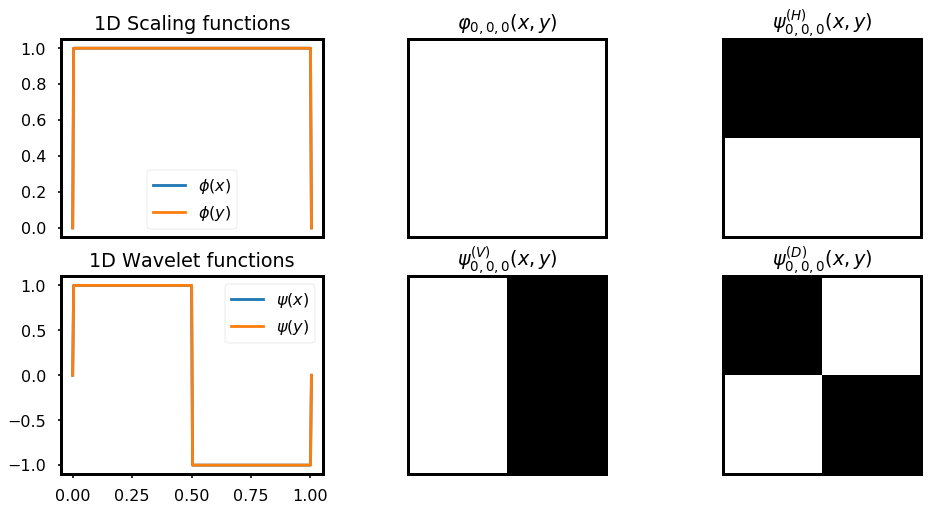

In [16]:
# Example
display_2DScaling_and_Wavelet_Functions()

## Interactive example


In [17]:
waveletList = ['haar', 'db2', 'sym4']
interactive(display_2DScaling_and_Wavelet_Functions, j=(0,1), m=(0,1), n=(0,1), wavelet=waveletList)

interactive(children=(IntSlider(value=0, description='j', max=1), IntSlider(value=0, description='m', max=1), IntSlider(value=0, description='n', max=1), Dropdown(description='wavelet', options=('haar', 'db2', 'sym4'), value='haar'), Output()), _dom_classes=('widget-interact',))